In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('surat_mvi.csv')

df.shape

(3103, 13)

In [3]:
df.duplicated().sum()

2

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.isna().sum()

location          0
bhk               0
areaType          0
square_feet       0
transaction       0
status            0
floorNum          0
totalFloor        0
furnishing        0
facing            0
price_per_sqft    0
price             0
built_up_area     0
dtype: int64

In [6]:
train_df = df.drop(columns=['square_feet','areaType', 'price_per_sqft', 'totalFloor'])

In [7]:
train_df.head()

,location,bhk,transaction,status,floorNum,furnishing,facing,price,built_up_area
0,palanpur,2,New Property,Ready to Move,5.0,Unfurnished,East,0.45,1185
1,dindoli,2,New Property,Under Construction,5.0,Unfurnished,West,0.34,708
2,palanpur,2,New Property,Under Construction,7.0,Unfurnished,East,0.46,1204
3,palanpur,2,New Property,Under Construction,6.0,Unfurnished,East,0.55,767
4,pal,2,New Property,Under Construction,5.0,Unfurnished,South -West,0.57,1351


# FloorNum

In [8]:
train_df = train_df[~(train_df['floorNum'] < 0)]

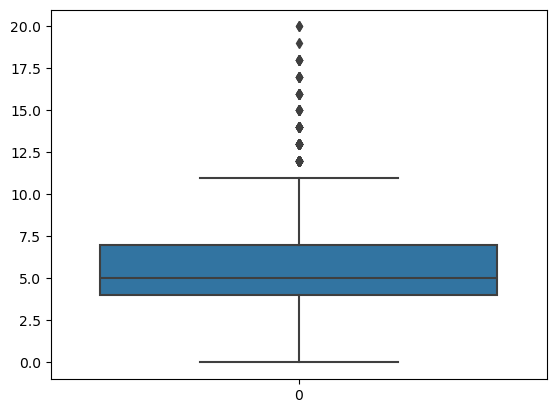

In [9]:
sns.boxplot(train_df['floorNum'])
plt.show()

In [10]:
def categorize_floor(floor):
    if 0 <= floor <= 2:
        return "Low Floor"
    elif 3 <= floor <= 10:
        return "Mid Floor"
    elif 11 <= floor <= 51:
        return "High Floor"
    else:
        return None  # or "Undefined" or any other label for floors outside the defined bins

train_df['floor_category'] = train_df['floorNum'].apply(categorize_floor)

# bathroom

In [11]:
train_df['bathroom'] = train_df['bhk'].apply(lambda x: max(1, x - 1))

# Luxury Score

In [12]:
def calculate_luxury_score(row):
    score = 0
    
    score += row['bhk'] * 10
    
    score += row['built_up_area'] // 100  # 1 point for every 100 sq ft
    
    score += row['price'] // 1e6  # 1 point for every million
    
    if row['furnishing'] == 'Furnished':
        score += 15
    elif row['furnishing'] == 'Semi-Furnished':
        score += 10
    else:
        score += 5
    
    score += row['bathroom'] * 5
    
    if row['floor_category'] == 'High Floor':
        score += 15
    elif row['floor_category'] == 'Mid Floor':
        score += 10
    else:
        score += 5
    
    return score

train_df['luxury_score'] = train_df.apply(calculate_luxury_score, axis=1)

In [13]:
train_df['luxury_score'].describe()

count    3089.000000
mean       70.545484
std        25.233327
min        25.000000
25%        52.000000
50%        68.000000
75%        80.000000
max       208.000000
Name: luxury_score, dtype: float64

<Axes: xlabel='luxury_score'>

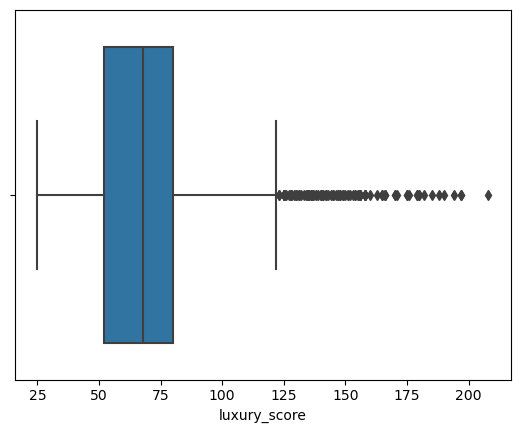

In [14]:
sns.boxplot(x=train_df['luxury_score'])

In [15]:
def categorize_luxury(score):
    if 0 <= score <= 50:
        return "Low"
    elif 50 < score <= 150:
        return "Medium"
    elif 150 < score <= 200:
        return "High"
    else:
        return None     

train_df['luxury_category'] = train_df['luxury_score'].apply(categorize_luxury)

In [16]:
train_df['luxury_category'].value_counts()

luxury_category
Medium    2398
Low        648
High        42
Name: count, dtype: int64

In [17]:
train_df.drop(columns=['floorNum','luxury_score'],inplace=True)

In [18]:
train_df.columns

Index(['location', 'bhk', 'transaction', 'status', 'furnishing', 'facing',
       'price', 'built_up_area', 'floor_category', 'bathroom',
       'luxury_category'],
      dtype='object')

ordinal encoding with unordered categories can work well with tree-based models, as these models can handle the ordinal values without interpreting them as actual "order." Tree-based models can effectively split on different levels without making assumptions about ordinal relationships.

In [19]:
from sklearn.preprocessing import OrdinalEncoder

# Create a copy of the original data for label encoding
data_label_encoded = train_df.copy()

categorical_cols = train_df.select_dtypes(include=['object']).columns

# Apply label encoding to categorical columns
for col in categorical_cols:
    oe = OrdinalEncoder()
    data_label_encoded[col] = oe.fit_transform(data_label_encoded[[col]])
    print(oe.categories_)

# Splitting the dataset into training and testing sets
X_label = data_label_encoded.drop('price', axis=1)
y_label = data_label_encoded['price']

[array(['adajan', 'althan', 'amroli', 'athwalines', 'bardoli', 'dindoli',
       'dumas road/hazira', 'jahangirpura', 'kadodara', 'kamrej',
       'katargam', 'nanpura/gopipura/chauta/sagrampura', 'pal',
       'palanpur', 'punagam', 'sachin', 'sarthana/varachha', 'udhna',
       'vesu'], dtype=object)]
[array(['New Property', 'Resale'], dtype=object)]
[array(['Ready to Move', 'Under Construction'], dtype=object)]
[array(['Furnished', 'Semi-Furnished', 'Unfurnished'], dtype=object)]
[array(['East', 'North', 'North - East', 'North - West', 'South',
       'South - East', 'South -West', 'West'], dtype=object)]
[array(['High Floor', 'Low Floor', 'Mid Floor'], dtype=object)]
[array(['High', 'Low', 'Medium', None], dtype=object)]


In [20]:
X_label

,location,bhk,transaction,status,furnishing,facing,built_up_area,floor_category,bathroom,luxury_category
0,13.0,2,0.0,0.0,2.0,0.0,1185,2.0,1,2.0
1,5.0,2,0.0,1.0,2.0,7.0,708,2.0,1,1.0
2,13.0,2,0.0,1.0,2.0,0.0,1204,2.0,1,2.0
3,13.0,2,0.0,1.0,2.0,0.0,767,2.0,1,1.0
4,12.0,2,0.0,1.0,2.0,6.0,1351,2.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...
3098,18.0,4,0.0,1.0,2.0,2.0,2057,2.0,3,2.0
3099,1.0,4,0.0,1.0,2.0,5.0,3600,2.0,3,2.0
3100,18.0,4,0.0,0.0,2.0,1.0,4500,2.0,3,2.0
3101,18.0,5,0.0,1.0,2.0,2.0,2475,2.0,4,2.0


In [21]:
y_label

0       0.45
1       0.34
2       0.46
3       0.55
4       0.57
        ... 
3098    1.88
3099    0.88
3100    1.88
3101    1.88
3102    1.88
Name: price, Length: 3089, dtype: float64

# Technique 1 - Correlation Analysis

<Axes: >

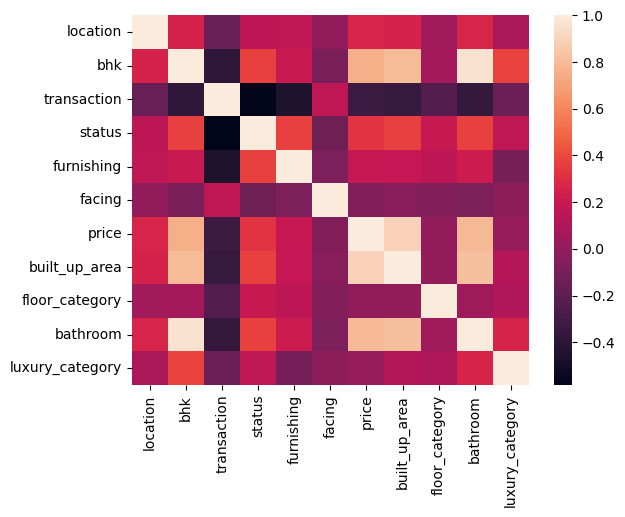

In [22]:
sns.heatmap(data_label_encoded.corr())

In [23]:
fi_df1 = data_label_encoded.corr()['price'].iloc[1:].to_frame().reset_index().rename(columns={'index':'feature','price':'corr_coeff'})
fi_df1

,feature,corr_coeff
0,bhk,0.758309
1,transaction,-0.332182
2,status,0.320258
3,furnishing,0.187341
4,facing,-0.064526
5,price,1.000000
6,built_up_area,0.892522
7,floor_category,-0.003711
8,bathroom,0.791298
9,luxury_category,0.020831


# Technique 2 - Random Forest Feature Importance

In [24]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df2 = pd.DataFrame({
    'feature': X_label.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

fi_df2

,feature,rf_importance
6,built_up_area,0.616001
1,bhk,0.149726
8,bathroom,0.145065
0,location,0.035580
9,luxury_category,0.020361
5,facing,0.010972
7,floor_category,0.007437
2,transaction,0.005407
4,furnishing,0.005264
3,status,0.004187


# Technique 3 - Gradient Boosting Feature importances

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Random Forest regressor on label encoded data
gb_label = GradientBoostingRegressor()
gb_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'feature': X_label.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
6,built_up_area,0.691979
1,bhk,0.155503
8,bathroom,0.098020
0,location,0.044669
5,facing,0.003133
9,luxury_category,0.002848
2,transaction,0.001382
3,status,0.001089
7,floor_category,0.000981
4,furnishing,0.000396


# Technique 4 - Permutation Importance

In [26]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': X_label.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

,feature,permutation_importance
6,built_up_area,0.817949
0,location,0.064379
8,bathroom,0.059715
1,bhk,0.050525
9,luxury_category,0.005992
7,floor_category,0.004750
3,status,0.002260
5,facing,0.001926
4,furnishing,0.000960
2,transaction,-0.003138


# Technique 5 - LASSO

- Not Reliable(because we used ordinal encoding)

In [27]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_label)

# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y_label)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X_label.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_df5

,feature,lasso_coeff
6,built_up_area,0.757345
8,bathroom,0.219320
0,location,0.032693
1,bhk,0.031082
7,floor_category,-0.000000
4,furnishing,-0.001504
3,status,-0.005641
5,facing,-0.010017
2,transaction,-0.013422
9,luxury_category,-0.128781


# Technique 6 - Recursive Feature Elimination

In [28]:
from sklearn.feature_selection import RFE

estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X_label.shape[1], step=1)
selector_label = selector_label.fit(X_label, y_label)

# Get the selected features based on RFE
selected_features = X_label.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

fi_df6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df6

,feature,rfe_score
6,built_up_area,0.597352
8,bathroom,0.162607
1,bhk,0.150266
0,location,0.037598
9,luxury_category,0.018434
5,facing,0.011417
7,floor_category,0.008026
4,furnishing,0.005066
2,transaction,0.004812
3,status,0.004422


# Technique 7 - Linear Regression Weights

- Not Reliable
  

In [29]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_label)

# Extract coefficients
fi_df7 = pd.DataFrame({
    'feature': X_label.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

fi_df7

,feature,reg_coeffs
6,built_up_area,0.755449
8,bathroom,0.208004
1,bhk,0.059694
0,location,0.043593
7,floor_category,-0.007438
5,facing,-0.019599
4,furnishing,-0.022228
3,status,-0.028331
2,transaction,-0.041093
9,luxury_category,-0.149193


In [30]:
final_fi_df = fi_df1.merge(fi_df2,on='feature').merge(fi_df3,on='feature').merge(fi_df4,on='feature').merge(fi_df5,on='feature').merge(fi_df6,on='feature').merge(fi_df7,on='feature').set_index('feature')

final_fi_df

,corr_coeff,rf_importance,gb_importance,permutation_importance,lasso_coeff,rfe_score,reg_coeffs
feature,,,,,,,
bhk,0.758309,0.149726,0.155503,0.050525,0.031082,0.150266,0.059694
transaction,-0.332182,0.005407,0.001382,-0.003138,-0.013422,0.004812,-0.041093
status,0.320258,0.004187,0.001089,0.002260,-0.005641,0.004422,-0.028331
furnishing,0.187341,0.005264,0.000396,0.000960,-0.001504,0.005066,-0.022228
facing,-0.064526,0.010972,0.003133,0.001926,-0.010017,0.011417,-0.019599
built_up_area,0.892522,0.616001,0.691979,0.817949,0.757345,0.597352,0.755449
floor_category,-0.003711,0.007437,0.000981,0.004750,-0.000000,0.008026,-0.007438
bathroom,0.791298,0.145065,0.098020,0.059715,0.219320,0.162607,0.208004
luxury_category,0.020831,0.020361,0.002848,0.005992,-0.128781,0.018434,-0.149193


In [31]:
final_fi_df = final_fi_df.divide(final_fi_df.sum(axis=0), axis=1)

final_fi_df[['rf_importance','gb_importance','permutation_importance','rfe_score']].mean(axis=1).sort_values(ascending=False)

feature
built_up_area      0.713260
bhk                0.131964
bathroom           0.121361
luxury_category    0.012404
facing             0.007141
floor_category     0.005532
status             0.003120
furnishing         0.003039
transaction        0.002180
dtype: float64

In [32]:
from sklearn.model_selection import cross_val_score, KFold

random_state = np.random.randint(1,100)
rf = RandomForestRegressor(n_estimators=100, random_state=random_state)

scores = cross_val_score(rf, X_label, y_label, cv=KFold(n_splits=5,shuffle=True,random_state=random_state), scoring='r2')
scores.mean()

0.8718852511189581

In [33]:
train_df.duplicated().sum()

84

In [34]:
train_df.drop_duplicates(inplace=True)

train_df.shape

(3005, 11)

In [35]:
train_df.isna().sum()

location           0
bhk                0
transaction        0
status             0
furnishing         0
facing             0
price              0
built_up_area      0
floor_category     0
bathroom           0
luxury_category    1
dtype: int64

In [36]:
train_df.dropna(inplace=True)

In [39]:
train_df = train_df[['location', 'bhk', 'built_up_area', 'transaction', 'status', 'furnishing', 'facing', 'bathroom', 'floor_category','luxury_category','price']]

In [40]:
train_df.reset_index(drop=True, inplace=True)

In [41]:
train_df.to_csv('surat_fs.csv', index=False)